In [1]:
import pandas as pd
import joblib
from features.extractor import FeatureExtractor
from features.final_processing import CustomColumnTransformer

import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

In [2]:
try:
    customers, sales = joblib.load('customers.joblib'), joblib.load('sales.joblib')
except:
    customers, sales = pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_customers'), pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_sales')
    joblib.dump(customers, 'customers.joblib')
    joblib.dump(sales, 'sales.joblib')

In [4]:
fe = FeatureExtractor(sales=sales, customers=customers, target_month=3, perform_split=False, generation_type='continuous', filtering_set='sales', period=60)
X_cont, y_cont = fe.transform()
fe = FeatureExtractor(sales=sales, customers=customers, target_month=3, perform_split=False, generation_type='categorical', filtering_set='sales', period=60)
X_cat, y_cat = fe.transform()

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/fedorturchenko/.cache/huggingface/token
Login successful
Successfully logged out.


In [4]:
cols_to_use = X_cont.columns.difference(X_cat.columns)
X = pd.concat(
    [
        X_cont[cols_to_use],
        X_cat,
    ],
    axis=1
)
X.drop('labour_cards_catalogue_consumables', axis=1, inplace=True)

In [5]:
col_transform = CustomColumnTransformer(
    cols_for_scaling=[col for col in X.columns if 'qty' in col],
    scaling_algo=StandardScaler(),
    cols_for_ohe=['segments', 'prodcatbroad', 'peak_hour', 'weekday', 'fuel_type'],
    cols_for_winsor=[col for col in X.columns if 'qty' in col],
    cols_to_skip=['last_purchase_share', 'full_non_fuel_purchase']
)

In [6]:
X_train, X_test, y_train, y_test = fe.perform_train_test_split(X, y_cont)

In [7]:
pipe = Pipeline(
    [
        ('column_transformer', col_transform),
        ('lightgbm', lgb.LGBMClassifier(n_jobs=7, random_state=571))
    ]
)

In [8]:
col_transform.fit_transform(X_train).columns

Index(['segments_frequent_drivers', 'segments_passerbys',
       'segments_regular_drivers', 'prodcatbroad_1', 'prodcatbroad_2',
       'prodcatbroad_3', 'prodcatbroad_4', 'prodcatbroad_5', 'prodcatbroad_6',
       'prodcatbroad_infrequent_sklearn', 'peak_hour_both',
       'peak_hour_peak_hours_qty', 'peak_hour_usual_hours_qty', 'weekday_both',
       'weekday_weekday_qty', 'weekday_weekend_qty', 'fuel_type_1',
       'fuel_type_2', 'fuel_type_3', 'fuel_type_4', 'fuel_type_5',
       'fuel_type_6', 'fuel_type_infrequent_sklearn', 'fuel_qty',
       'peak_hours_qty', 'unleaded_95_qty', 'usual_hours_qty', 'weekday_qty',
       'weekend_qty', 'last_purchase_share', 'full_non_fuel_purchase'],
      dtype='object')

In [9]:
col_transform.fit_transform(X_test).columns

Index(['segments_frequent_drivers', 'segments_passerbys',
       'segments_regular_drivers', 'prodcatbroad_1', 'prodcatbroad_2',
       'prodcatbroad_3', 'prodcatbroad_4', 'prodcatbroad_5', 'prodcatbroad_6',
       'prodcatbroad_infrequent_sklearn', 'peak_hour_both',
       'peak_hour_peak_hours_qty', 'peak_hour_usual_hours_qty', 'weekday_both',
       'weekday_weekday_qty', 'weekday_weekend_qty', 'fuel_type_1',
       'fuel_type_2', 'fuel_type_3', 'fuel_type_4', 'fuel_type_5',
       'fuel_type_6', 'fuel_type_infrequent_sklearn', 'fuel_qty',
       'peak_hours_qty', 'unleaded_95_qty', 'usual_hours_qty', 'weekday_qty',
       'weekend_qty', 'last_purchase_share', 'full_non_fuel_purchase'],
      dtype='object')

In [10]:
pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

[LightGBM] [Info] Number of positive: 29528, number of negative: 25893
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 55421, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532794 -> initscore=0.131366
[LightGBM] [Info] Start training from score 0.131366


In [11]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     25893
           1       0.78      0.78      0.78     29528

    accuracy                           0.77     55421
   macro avg       0.77      0.77      0.77     55421
weighted avg       0.77      0.77      0.77     55421



In [12]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74      8708
           1       0.77      0.77      0.77      9766

    accuracy                           0.76     18474
   macro avg       0.76      0.76      0.76     18474
weighted avg       0.76      0.76      0.76     18474



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

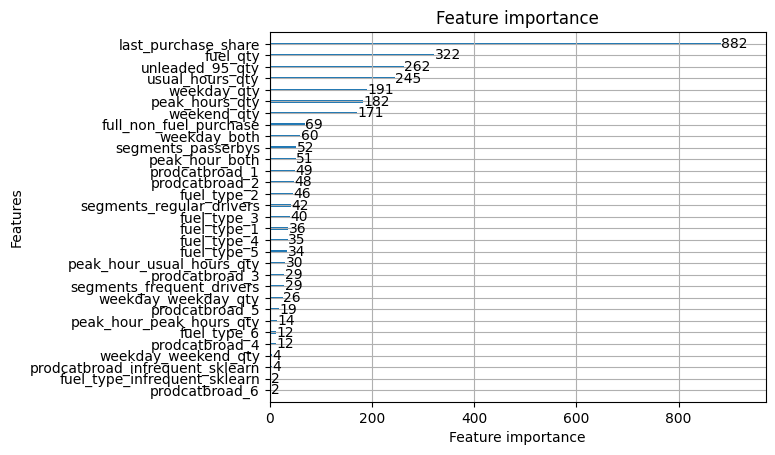

In [14]:
lgb.plot_importance(pipe.get_params()['lightgbm'])

In [13]:
X_train, X_test, y_train, y_test = fe.perform_train_test_split(X_cont, y_cont)

In [85]:
col_transform = CustomColumnTransformer(
    cols_for_scaling=[col for col in X_train.columns if 'qty' in col],
    scaling_algo=StandardScaler(),
    cols_for_ohe=['segments'],
    cols_for_winsor=[col for col in X_train.columns if 'qty' in col],
    cols_to_skip=['last_purchase_share', 'full_non_fuel_purchase', 'labour_cards_catalogue_consumables']
)

In [86]:
pipe = Pipeline(
    [
        ('column_transformer', col_transform),
        ('lightgbm', lgb.LGBMClassifier(n_jobs=7, random_state=571))
    ]
)

In [87]:
pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

[LightGBM] [Info] Number of positive: 29528, number of negative: 25893
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 55421, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532794 -> initscore=0.131366
[LightGBM] [Info] Start training from score 0.131366


In [88]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     25893
           1       0.78      0.78      0.78     29528

    accuracy                           0.77     55421
   macro avg       0.77      0.77      0.77     55421
weighted avg       0.77      0.77      0.77     55421



In [89]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      8708
           1       0.77      0.77      0.77      9766

    accuracy                           0.76     18474
   macro avg       0.76      0.76      0.76     18474
weighted avg       0.76      0.76      0.76     18474



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

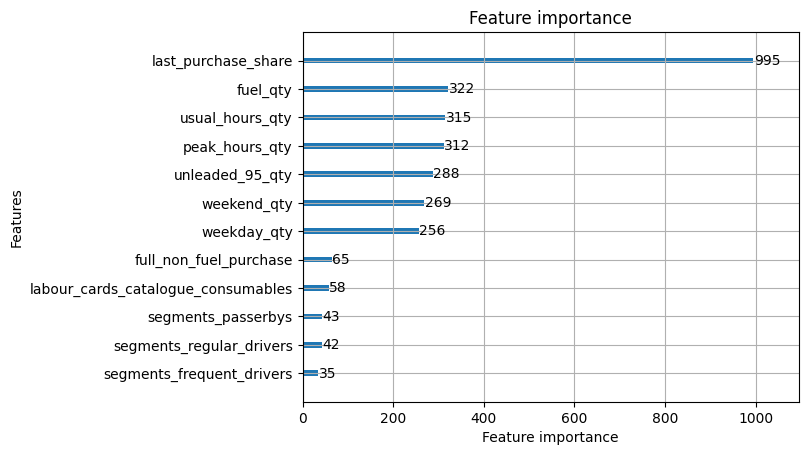

In [90]:
lgb.plot_importance(pipe.get_params()['lightgbm'])

In [66]:
X_cat = pd.concat(
    [
        X_cat.select_dtypes(include=['float64', 'category']),
        X_cat.select_dtypes(include=['int64', 'object']).astype('category')
    ],
    axis=1
)

In [69]:
X_train, X_test, y_train, y_test = fe.perform_train_test_split(X_cat, y_cat)

In [70]:
cat = CatBoostClassifier(cat_features=[col for col in X_train.columns if col!='last_purchase_share'], random_seed=571)

In [71]:
cat.fit(X_train, y_train)
train_preds = cat.predict(X_train)
test_preds = cat.predict(X_test)

Learning rate set to 0.057211
0:	learn: 0.6736733	total: 26.1ms	remaining: 26s
1:	learn: 0.6560967	total: 47.1ms	remaining: 23.5s
2:	learn: 0.6412041	total: 62.2ms	remaining: 20.7s
3:	learn: 0.6276683	total: 82.2ms	remaining: 20.5s
4:	learn: 0.6162820	total: 96.4ms	remaining: 19.2s
5:	learn: 0.6060400	total: 113ms	remaining: 18.7s
6:	learn: 0.5968471	total: 131ms	remaining: 18.6s
7:	learn: 0.5882282	total: 152ms	remaining: 18.8s
8:	learn: 0.5810051	total: 169ms	remaining: 18.6s
9:	learn: 0.5746823	total: 186ms	remaining: 18.4s
10:	learn: 0.5690100	total: 204ms	remaining: 18.4s
11:	learn: 0.5639960	total: 227ms	remaining: 18.7s
12:	learn: 0.5595365	total: 253ms	remaining: 19.2s
13:	learn: 0.5555559	total: 274ms	remaining: 19.3s
14:	learn: 0.5519393	total: 296ms	remaining: 19.5s
15:	learn: 0.5488860	total: 315ms	remaining: 19.4s
16:	learn: 0.5463423	total: 333ms	remaining: 19.3s
17:	learn: 0.5438092	total: 353ms	remaining: 19.2s
18:	learn: 0.5415810	total: 368ms	remaining: 19s
19:	learn:

In [72]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74     25893
           1       0.76      0.80      0.78     29528

    accuracy                           0.76     55421
   macro avg       0.76      0.76      0.76     55421
weighted avg       0.76      0.76      0.76     55421



In [73]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      8708
           1       0.76      0.79      0.77      9766

    accuracy                           0.76     18474
   macro avg       0.76      0.75      0.75     18474
weighted avg       0.76      0.76      0.76     18474



<BarContainer object of 7 artists>

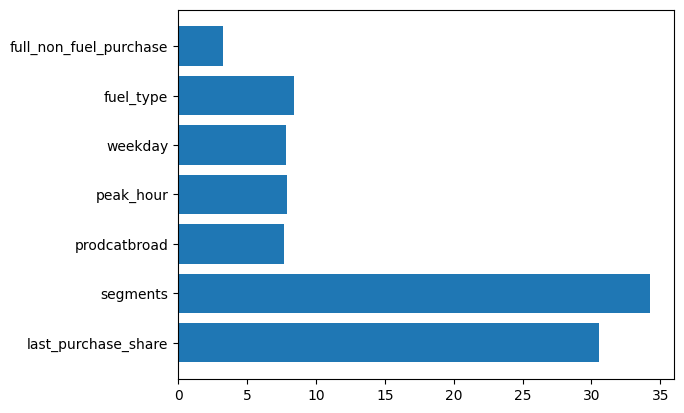

In [74]:
importances = cat.feature_importances_
names = cat.feature_names_
plt.barh(names, importances)